* how to align signals? Board A/B
* where is u diode of quenched magnet
* only one signal per crate, where are the others?
* u_diode of arc magnets? get reference signals?

In [4]:
from lhcsmapi.metadata import signal_metadata
from lhcsmapi.api import query, processing, resolver
from nxcals.api.extraction.data.builders import DataQuery, DevicePropertyDataQuery
from lhcsmapi.analysis.RbCircuitQuery import RbCircuitQuery
from lhcsmapi.api import processing
from lhcsmapi.metadata.MappingMetadata import MappingMetadata

import matplotlib.pyplot as plt
import numpy as np
timestamp_fgc = 1616962174400000000

query_builder = RbCircuitQuery('RB', 'RB.A78')
source_timestamp_nqps_df = query_builder.find_source_timestamp_nqps(timestamp_fgc, warn_on_missing_pm_buffers=True) #timestamp from all crates

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-28 22:09:24.400 to 2021-03-28 22:16:14.400


154


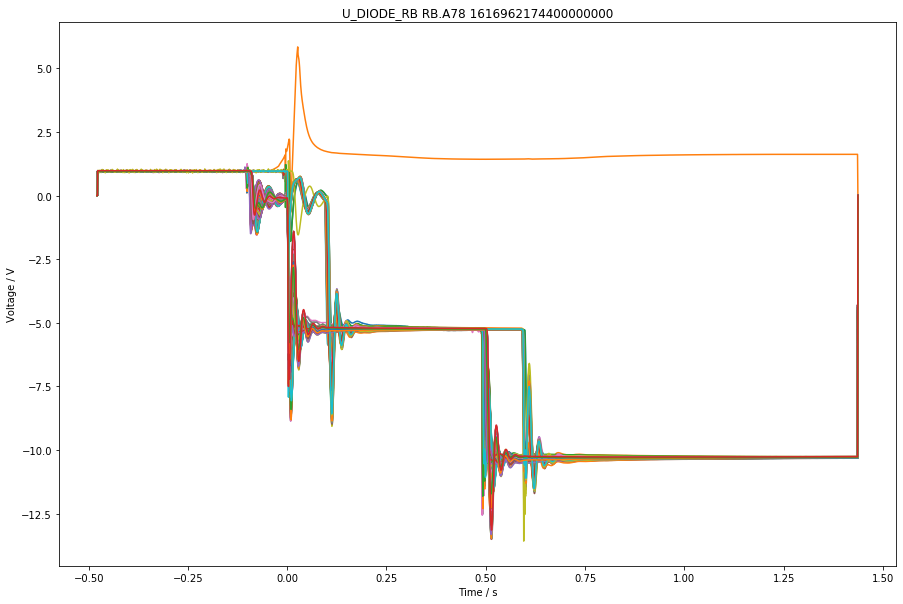

In [5]:
fig, ax = plt.subplots(figsize=(15,10))
pm_data = []

pm_system = 'QPS'
pm_class = 'DQAMGNSRB_PMREL'
pm_source = '*'
df_metadata = MappingMetadata.read_crate_to_magnet_and_vf_mapping('RB')
for index, row in source_timestamp_nqps_df.iterrows():
    wildcard = {'MAGNET': '*', 'QPS_CRATE': row['source']}
    params = resolver.get_params_for_pm_signals('RB', 'RB.A78', 'DIODE_RB', row['timestamp'],signals=['U_DIODE_RB'], wildcard=wildcard)
    data = query.query_pm_signals_with_resolved_params(params)

    data_processed = processing.SignalProcessing(data).synchronize_time(row['timestamp']).convert_index_to_sec().get_dataframes()
    if isinstance(data_processed, list):
        for d in data_processed:
            d.plot(ax=ax, legend=False)
            pm_data.append(d)
            if d.empty:
                print('empty')
    else:
        data_processed.plot(ax=ax, legend=False)
        pm_data.append(data_processed)
        if data_processed.empty:
            print('empty')

print(len(pm_data))
plt.title('U_DIODE_RB RB.A78 1616962174400000000')
plt.xlabel('Time / s')
plt.ylabel('Voltage / V')
plt.show()

Querying Post Mortem failed using the following query: http://pm-rest.cern.ch/v2/pmdata/signal?system=QPS&className=DQAMGNSRB_PMREL&source=*&timestampInNanos=1616962178515000000&signal=MB.A26R7:U_DIODE_RB
Querying Post Mortem failed using the following query: http://pm-rest.cern.ch/v2/pmdata/signal?system=QPS&className=DQAMGNSRB_PMREL&source=*&timestampInNanos=1616962178515000000&signal=MB.C26R7:U_DIODE_RB
Querying Post Mortem failed using the following query: http://pm-rest.cern.ch/v2/pmdata/signal?system=QPS&className=DQAMGNSRB_PMREL&source=*&timestampInNanos=1616962178515000000&signal=MB.B27R7:U_DIODE_RB
Querying Post Mortem failed using the following query: http://pm-rest.cern.ch/v2/pmdata/signal?system=QPS&className=DQAMGNSRB_PMREL&source=*&timestampInNanos=1616962178515000000&signal=MB.C33L8:U_DIODE_RB
Querying Post Mortem failed using the following query: http://pm-rest.cern.ch/v2/pmdata/signal?system=QPS&className=DQAMGNSRB_PMREL&source=*&timestampInNanos=1616962178515000000&si

121

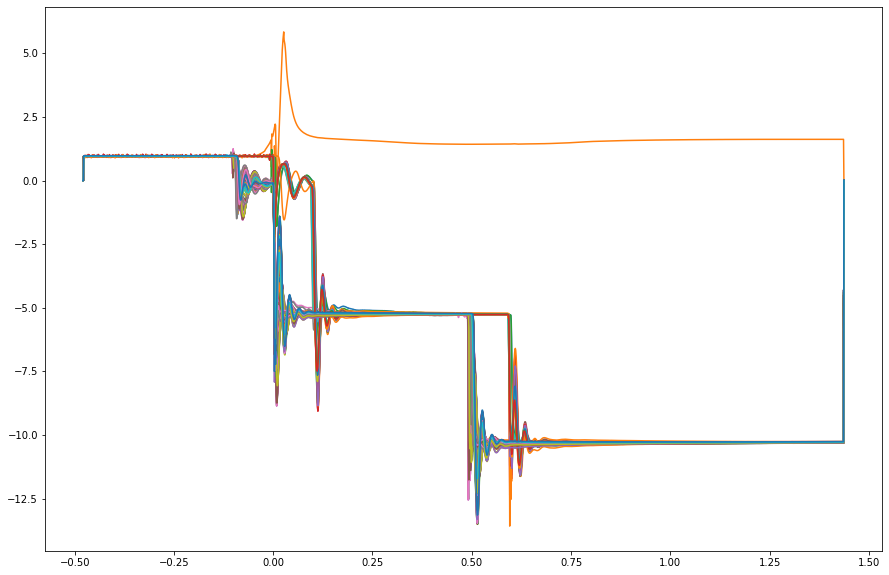

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
df_metadata = MappingMetadata.read_crate_to_magnet_and_vf_mapping('RB')
pm_data=[]
for index, row in source_timestamp_nqps_df.iterrows():
    crate_entries = df_metadata[df_metadata.Crate==row['source']].filter(regex='Magnet').values[0]
    
    delete_signals = [np.nan, 'U_REF_N1']
    signals = [m + ':U_DIODE_RB' for m in crate_entries if not m in delete_signals]

    for signal in signals:
        data = query.query_pm_signals(pm_system, pm_class, pm_source, signal, row['timestamp'])
        if not data.empty:
            pm_data.append(data)
            
            data_processed = processing.SignalProcessing(data).synchronize_time(row['timestamp']).convert_index_to_sec().get_dataframes()
            data_processed.plot(ax=ax, legend=False)
len(pm_data)